In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from functools import partial
import math
import warnings

In [2]:
class graphics_window:
    
    def __init__(self, window_resolution):
        self.window_height = window_resolution[1]
        self.window_width = window_resolution[0]
        self.window_data = np.full((self.window_height, self.window_width, 3), 0)
        self.height_offset = self.window_height // 2
        self.width_offset = self.window_width // 2
        self.z_buffer = np.full((self.window_height, self.window_width, 4), 0)
        self.z_buffer[:,:,3] = np.full((self.window_height, self.window_width), 9223372036854775807)
        
    def display(self, display_size=(8, 8)):
        plt.figure(figsize=display_size)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.imshow(self.window_data, animated=False)
    
    def animate(self, set_frame, frame_count=None, interval=10, display_size=(8,8)):
        fig = plt.figure(figsize = display_size)
        plt.xticks([], [])
        plt.yticks([], [])
        im = plt.imshow(self.window_data, animated=True)
        def get_frame(i):
            set_frame(self, i)
            im.set_data(self.window_data)
            return im,
        anim = animation.FuncAnimation(fig, get_frame, 
                                       frames=frame_count, interval=10, blit=False)
        return anim        
            
    
    def get_window_data(self):
        return self.window_data
    
    def on_pixel(self, x, y, rgb=(255, 255, 255)):
        r, g, b = rgb
        if (0 <= self.height_offset - y < self.window_height) and \
           (0 <= x + self.width_offset < self.window_width) :
            self.window_data[self.height_offset - y, x + self.width_offset, 0] = r
            self.window_data[self.height_offset - y, x + self.width_offset, 1] = g
            self.window_data[self.height_offset - y, x + self.width_offset, 2] = b
        else:
            warnings.warn("Attempted setting a pixel outside window")
    
    def on_z_pixel(self, x, y, rgb=(255, 255, 255)):
        r, g, b = rgb
        if (0 <= self.height_offset - y < self.window_height) and \
           (0 <= x + self.width_offset < self.window_width) :
            self.z_buffer[self.height_offset - y, x + self.width_offset, 0] = r
            self.z_buffer[self.height_offset - y, x + self.width_offset, 1] = g
            self.z_buffer[self.height_offset - y, x + self.width_offset, 2] = b
        else:
            warnings.warn("Attempted setting a pixel outside z window")
    
    def set_z_depth(self, x, y, z):
        if (0 <= self.height_offset - y < self.window_height) and \
           (0 <= x + self.width_offset < self.window_width) :
            self.z_buffer[self.height_offset - y, x + self.width_offset, 3] = z
        else:
            warnings.warn("Attempted setting a pixel outside z window")
            
    def get_z_depth(self, x, y):
        if (0 <= self.height_offset - y < self.window_height) and \
           (0 <= x + self.width_offset < self.window_width) :
            return self.z_buffer[self.height_offset - y, x + self.width_offset, 3]
        return None
    
    def populate_window_from_z_buffer(self):
        self.window_data = self.z_buffer[:,:,0:3]
        self.z_buffer = np.full((self.window_height, self.window_width, 4), 0)
        self.z_buffer[:,:,3] = np.full((self.window_height, self.window_width), 9223372036854775807)
    
    def clear(self):
        self.window_data.fill(0)

<IPython.core.display.Javascript object>


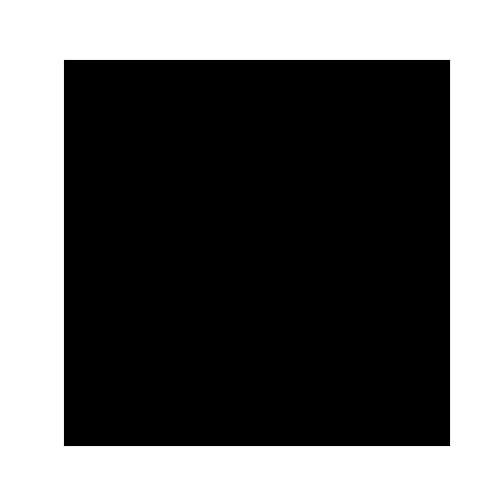

In [3]:
window = graphics_window((801, 801))
window.display((5,5))

In [4]:
def bresenham_2d_line_internal(window, start_x, start_y, end_x, end_y, line_type):
    assert start_x <= end_x, \
    'bresenham_2d_line_internal only handles case where start_x <= end_x'
    assert end_x == start_x or (end_y - start_y) / (end_x - start_x) <= 1, \
    'bresenham_2d_line_internal only handles case where slope lies in [-1, 1] or is undefined'
    
    if line_type == 'horizontal' or line_type == 'vertical':
        x = start_x
        y = start_y
        while x <= end_x:
            if line_type == 'horizontal':
                window.on_pixel(x, y)
            elif line_type == 'vertical':
                window.on_pixel(y, x)
            x += 1
    else:
        A = end_y - start_y
        B = start_x - end_x
        y_incr = 1
        if A < 0:
            y_incr = -1
            A = -A   
        d = 2*A + B
        x = start_x
        y = start_y
        while x <= end_x:
            if line_type == 'low':
                window.on_pixel(x, y)
            elif line_type == 'high':
                window.on_pixel(y, x)
            if d <= 0:
                d += 2 * A
                x += 1
            else:
                d += 2 * (A+B)
                x += 1
                y += y_incr      
        
def bresenham_2d_line(window, start_coordinate, end_coordinate):
    start_x, start_y = start_coordinate
    end_x, end_y = end_coordinate
    if start_y == end_y:
        if start_x <= end_x:
            bresenham_2d_line_internal(window, start_x, start_y, end_x, end_y, 'horizontal')
        else:
            bresenham_2d_line_internal(window, end_x, end_y, start_x, start_y, 'horizontal')
    elif start_x == end_x:
        if start_y <= end_y:
            bresenham_2d_line_internal(window, start_y, start_x, end_y, end_x, 'vertical')
        else:
            bresenham_2d_line_internal(window, end_y, end_x, start_y, start_x, 'vertical')
    elif abs(end_y - start_y) / abs(end_x - start_x) <= 1:
        if start_x < end_x:
            bresenham_2d_line_internal(window, start_x, start_y, end_x, end_y, 'low')
        else:
            bresenham_2d_line_internal(window, end_x, end_y, start_x, start_y, 'low')
    else:
        if start_y < end_y:
            bresenham_2d_line_internal(window, start_y, start_x, end_y, end_x, 'high')
        else:
            bresenham_2d_line_internal(window, end_y, end_x, start_y, start_x, 'high')

In [5]:
def bresenham_2d_polygon(window, vertex_2d_sequence):
    vertex_count = vertex_2d_sequence.shape[0]
    for i in range(vertex_count):
        bresenham_2d_line(window, vertex_2d_sequence[i], vertex_2d_sequence[(i+1)%vertex_count])

In [6]:
def control_points_3d_wrt_eye(eye_3d, screen_distance, control_points_3d):
    r = eye_3d[0]
    sinth = np.sin(eye_3d[1])
    costh = np.cos(eye_3d[1])
    sinph = np.sin(eye_3d[2])
    cosph = np.cos(eye_3d[2])
    V = [[-sinth, -cosph*costh, -sinph*costh, 0],
        [costh, -cosph*sinth, -sinph*sinth, 0],
        [0, sinph, -cosph, 0],
        [0, 0, r, 1]]
    control_points_3d_h = np.hstack((control_points_3d, 
                                     np.ones((control_points_3d.shape[0], 1), 
                                             dtype=control_points_3d.dtype)))
    control_points_3d_eye = np.delete(control_points_3d_h@V, -1, 1)
    return control_points_3d_eye

In [7]:
def control_points_3d_to_2d(eye_3d, screen_distance, control_points_3d):
    r = eye_3d[0]
    sinth = np.sin(eye_3d[1])
    costh = np.cos(eye_3d[1])
    sinph = np.sin(eye_3d[2])
    cosph = np.cos(eye_3d[2])
    V = [[-sinth, -cosph*costh, -sinph*costh, 0],
        [costh, -cosph*sinth, -sinph*sinth, 0],
        [0, sinph, -cosph, 0],
        [0, 0, r, 1]]
    control_points_3d_h = np.hstack((control_points_3d, 
                                     np.ones((control_points_3d.shape[0], 1), 
                                             dtype=control_points_3d.dtype)))
    control_points_3d_eye = np.delete(control_points_3d_h@V, -1, 1)
    control_points_2d = np.int64(screen_distance * np.delete(
        (control_points_3d_eye / control_points_3d_eye[:,2][:, None]), -1, 1))
    return control_points_2d

In [8]:
def read_planar_patches(file):
    planar_patches = []
    with open(file) as f:
        for line in f:
            coordinates = np.array(list(map(np.float64, line.split())))
            planar_patch = coordinates.reshape((coordinates.shape[0]//3, 3))
            planar_patches.append(planar_patch)
    return np.array(planar_patches)

In [9]:
def draw_object(window, planar_patches, eye_3d, screen_distance, display=False):
    pps = planar_patches
    for pp in pps:
        v_2d_s = control_points_3d_to_2d(eye_3d, screen_distance, pp)
        bresenham_2d_polygon(window, v_2d_s) 
    if display:
        window.display()
        window.clear()

<IPython.core.display.Javascript object>


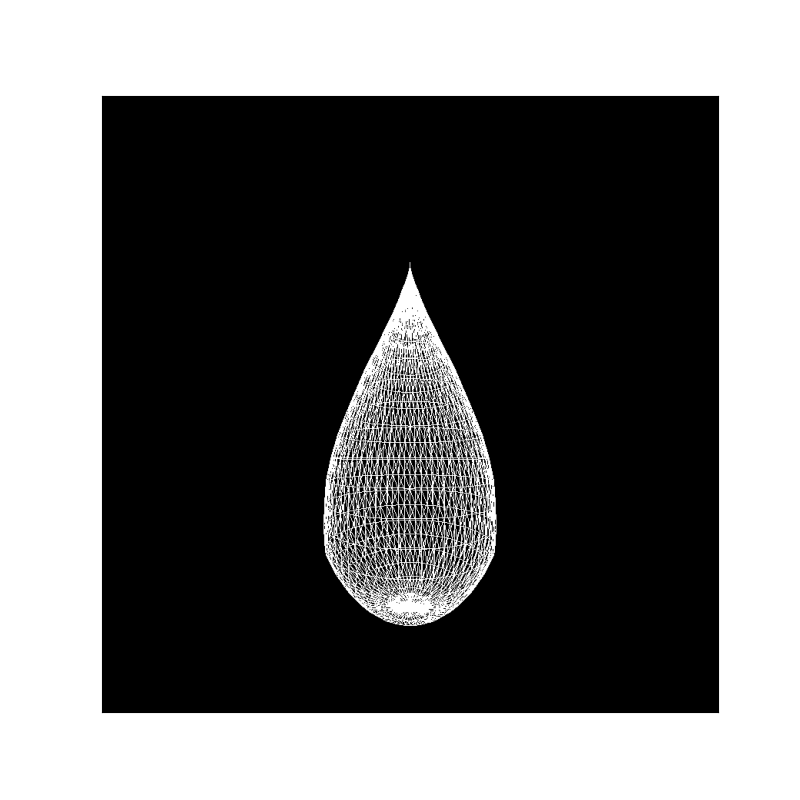

In [10]:
delta = 64
sequence = np.arange(0, 2*np.pi, np.pi/delta)

def set_obj_frames(window, i):
    window.clear()
    draw_object(window, read_planar_patches('droplet.txt'), (400, 0, sequence[i]), 300)

v = window.animate(set_obj_frames, frame_count=len(sequence), interval=1000, display_size=(8, 8))

<IPython.core.display.Javascript object>


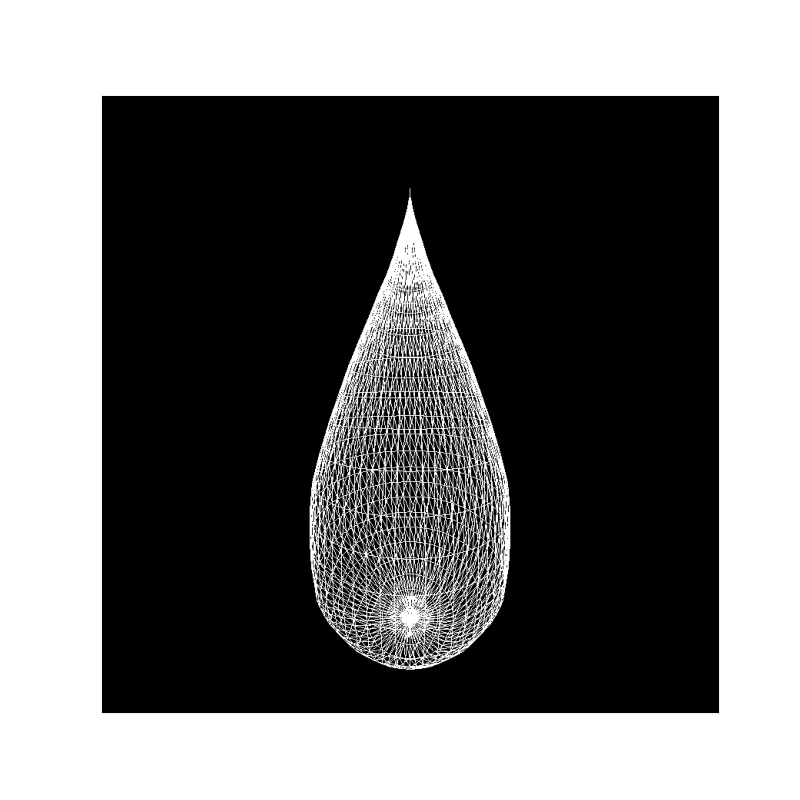

In [12]:
delta = 64
sequence = np.arange(0, 2*np.pi, np.pi/delta)

def set_obj_frames(window, i):
    window.clear()
    draw_object(window, read_planar_patches('droplet.txt'), (300, sequence[i], np.pi/2), 280)

h = window.animate(set_obj_frames, frame_count=len(sequence), interval=1000, display_size=(8,8))

<IPython.core.display.Javascript object>


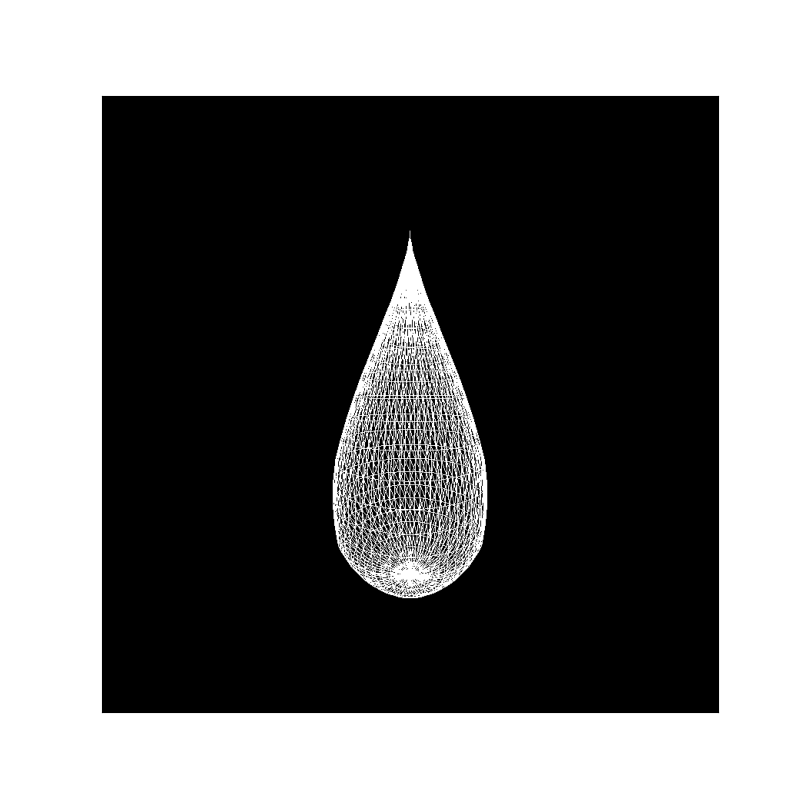

In [13]:
delta = 20
sequence = np.append(np.arange(700, 300, -delta), np.arange(300, 700, delta)) 

def set_obj_frames(window, i):
    window.clear()
    draw_object(window, read_planar_patches('droplet.txt'), (sequence[i], np.pi/8, np.pi/2), 300, False)

m = window.animate(set_obj_frames, frame_count=len(sequence), interval=500, display_size=(8,8))